<a href="https://colab.research.google.com/github/dabandaidai/CSC413/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import datetime
import os
import cv2
import pandas as pd
from typing import Tuple

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# CSC413 Project: Chinese Handwritten Character Recognition
### Model 1: Kurdish Handwritten Character Recognition using Deep Learning Techniques [Ahmed et al.]

# Note

* (March 13, 2023): The original Kurdish model takes in images of dimensions 180x180x3. Our Chinese MNIST images have dimensions 64x64x1. As they have smaller width and height, and the (unmodified) Kurdish model does not use padding in maxpooling layers, if we feed them directly into it, the width and height of the output of the layers eventually vanish, leading to error. We have a few choices:

  1. add padding to the maxpooling layers
  2. remove some maxpooling layers
  3. resize the Chinese MNIST images to 180x180x1

  We the current strategy is to resize the images.
*  (March 13, 2023): We are training the Kurdish model on images of dimensions 180x180x1 instead of 180x180x3 (the dimensions of the images in the Kurdish dataset the model was originally intended for).

In [2]:
"""
Mount Google drive and load the dataset folder into the runtime.
"""
def load_dataset():
  if not os.path.exists("./chinese_mnist"):
    !unzip /content/drive/MyDrive/CSC413_Project/datasets/chinese_mnist.zip > /dev/null


"""
TOD: We may need to add one dimension to the output numpy arrays for the grayscale colour channel.

Return images and labels, for training, validation and test dataset.
"""
def prepare_dataset() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
  csv = pd.read_csv("/content/chinese_mnist/chinese_mnist.csv")

  images = np.array([ cv2.resize(cv2.imread(f"/content/chinese_mnist/data/data/input_{suite_id}_{sample_id}_{code}.jpg", cv2.IMREAD_GRAYSCALE), (180, 180)) for suite_id, sample_id, code in csv[['suite_id', 'sample_id', 'code']].values ])
  labels = np.array([ x - 1 for x in csv['code'].values ]) # need to compensate to 0-15

  indices = np.arange(len(images))

  np.random.seed(413) 
  np.random.shuffle(indices)

  splited_indices = np.split(indices, [int(images.shape[0] * 0.6), int(images.shape[0] * 0.7)])

  return (images[splited_indices[0]], labels[splited_indices[0]], 
          images[splited_indices[1]], labels[splited_indices[1]], 
          images[splited_indices[2]], labels[splited_indices[2]])


"""
Return training, validation and test dataloaders.
"""
def dataloader(training_images: np.ndarray, training_labels: np.ndarray, 
               validation_images: np.ndarray, validation_labels: np.ndarray, 
               test_images: np.ndarray, test_labels: np.ndarray,
               batch_size: int) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
  
  return (tf.data.Dataset.from_tensor_slices((training_images, training_labels)).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE),
          tf.data.Dataset.from_tensor_slices((validation_images, validation_labels)).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE),
          tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE))

"""
Return the Kurdish model.
"""
def kurdish_model(image_height: int, image_width: int, number_of_channels: int, number_of_classes: int):
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(image_height, image_width, number_of_channels)), 
        layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.MaxPooling2D(),  
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(512, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(number_of_classes)
        ])
    
    with tf.device("/gpu:0"):
        model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) # try the string 'accuracy'.
    
    return model


"""
Train a model.
"""
def train(model: tf.keras.Model, training_dataloader: tf.data.Dataset, validation_dataloader: tf.data.Dataset, number_of_epochs: int) -> tf.keras.callbacks.History:
  return model.fit(training_dataloader,
                   validation_data=validation_dataloader,
                   epochs=number_of_epochs)

## Set up the dataset

In [3]:
load_dataset()
training_images, training_labels, validation_images, validation_labels, test_images, test_labels = prepare_dataset()

## Check the dimensions of the image and label numpy arrays

In [4]:
print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)
print(test_images.shape)
print(test_labels.shape)
assert(training_images.shape[0] + validation_images.shape[0] + test_images.shape[0] == 15000)

(9000, 180, 180)
(9000,)
(1500, 180, 180)
(1500,)
(4500, 180, 180)
(4500,)


## Hyperparameters

In [5]:
IMAGE_HEIGHT = training_images[0].shape[0]
IMAGE_WIDTH = training_images[0].shape[1]
NUMBER_OF_CLASSES = 16
BATCH_SIZE = 32
NUMBER_OF_EPOCHS = 10 # TODO: read the Kurdish paper to find out how many epochs they trained for.

## Dataloaders

In [6]:
training_dataloader, validation_dataloader, test_dataloader = dataloader(training_images, training_labels, validation_images, validation_labels, test_images, test_labels, BATCH_SIZE)


## Checking the dimensions of a batch

In [7]:
for image_batch, label_batch in training_dataloader:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 180, 180)
(32,)


## Visualize the first 9 images in the training dataset

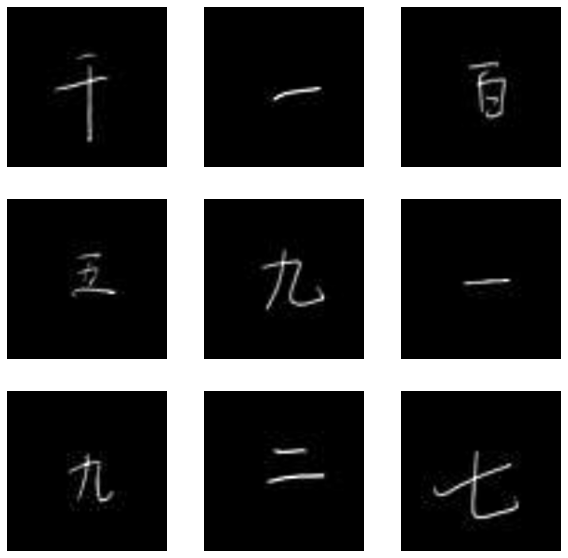

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataloader.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.axis("off")
# TODO: find a way to display the labels as well.

## Create model

In [9]:
kurdish_model = kurdish_model(IMAGE_HEIGHT, IMAGE_WIDTH, 1, NUMBER_OF_CLASSES)

## Model summary

In [10]:
kurdish_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 32)        4

## Training

In [11]:
# TODO: train the model by running this cell
# TODO: monitor the losses to adjust hyperparameters

history = train(kurdish_model, training_dataloader, validation_dataloader, NUMBER_OF_EPOCHS)

Epoch 1/10
 17/282 [>.............................] - ETA: 6:31 - loss: 2.7691 - sparse_categorical_accuracy: 0.0680

KeyboardInterrupt: ignored

## Visualize training results

In [ ]:
# TODO

## Predict on new data

In [ ]:
# TODO

## Saving model

In [ ]:
# TODO